<a href="https://colab.research.google.com/github/ifrahsaleem/Airbnb2019/blob/master/Airbnb_Python_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Ifrah Saleem 
Date: 16/05/2020



#Introduction

New York is a densely populated state with around 62 million tourists visiting it per year, consequently there are a lot of airbnb rentals in NYC. We have a NYC Airbnb dataset which contains about 50000 airbnb listings. We will exeplore and analyze the the attributes of this dataset to see whether there is a correlation between price and different attributes.


#Problem Definition

The goal of this project is to find whether the price of the airbnb can be predicted using various features. 

For this purpose, 3 external datasets are being used:

1.   Airports in USA
2.   Subway Entrances and Exit in NYC
3.   Parks and Events in NYC 

The only attributes that will be used from these dataset are latitude and longitude, to test whether nearby airports, subway station, and park or events, in addition to features from the main data set can have an affect on the price of the airbnb.

This project is divided into 3 parts:

1.   Correlation of Airbnb Price with Other Factors 

    We assume that features like nearest distance from subway entrance, nearest distance from airport, nearest distance from parks/eventstype will show strong correlation with price.
    
2.   Hypothesis Testing 
3.   Applying Machine Learning model to find Airbnb Recommendations 
 


#Part 1: Correlation of Airbnb Price with Other Factors

In this section, we explore all our datasets, plot the distributions and try to visualize any correlation of price with other features in the dataset

In [0]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np 
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
!pip install geopy
!pip install geopandas
import geopandas as gpd
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial import KDTree
from scipy.spatial import cKDTree
from geopy.distance import geodesic
import timeit
import folium
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 931kB 2.7MB/s 
     |████████████████████████████████| 14.7MB 236kB/s 
     |████████████████████████████████| 10.9MB 44.5MB/s 


In [0]:
data_path = "/content/gdrive/My Drive"
filename = "AB_NYC_2019.csv"

df = pd.read_csv(join(data_path, filename), delimiter=",")

##Understanding The Airbnb Data 

In [0]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [0]:
df.shape

(48895, 16)

In [0]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [0]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


##Manipulating The Airbnb Data 

In [0]:
df.isnull().sum() / df.shape[0]

id                                0.000000
name                              0.000327
host_id                           0.000000
host_name                         0.000429
neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
last_review                       0.205583
reviews_per_month                 0.205583
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

In [0]:
df = df.drop(columns = "name")

In [0]:
df = df.drop(columns = "host_name" )
df = df.drop(columns = "last_review" )
df = df.drop(columns = "reviews_per_month" )

##Boroughs of New York 

####Analyzing The Distribution of Airbnbs in Each Borough

This plot helps us visualize the spread of airbnb within each borough. It can be seen that the Staten Island is least populated with Airbnbs while Brooklyn and Manhattan seem the most populated.

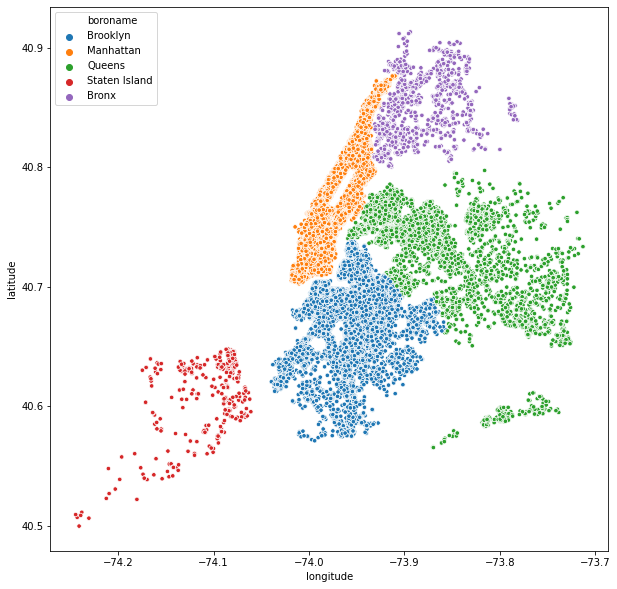

In [0]:
#Rename a column to accurately reflect Boroughs
df.rename(columns={'neighbourhood_group':'boroname'}, inplace=True)
#Review the listings by boroname
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude', hue='boroname',s=20, data=df)

####Displaying Airbnb Count in Each Borough

This is a numerical representation of the spread and number of Airbnbs in each Borough. It displays that Manhattan and Brooklyn have the highest number of Airbnbs while Staten Island has the least. 

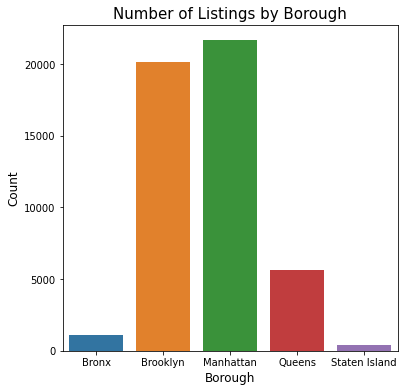

In [0]:
#Get a count by borough
borough_count = df.groupby('boroname').agg('count').reset_index()
#Plot the count by borough
fig, ax1 = plt.subplots(1,1, figsize=(6,6)
                       )
sns.barplot(x='boroname', y='id', data=borough_count, ax=ax1)

ax1.set_title('Number of Listings by Borough', fontsize=15)
ax1.set_xlabel('Borough', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='both', labelsize=10)


####Analyzing Room Type in Each Borough

This scatterplot helps to visualize the type of room available in each Borough. The result shows that each type of room is available in each Borough.

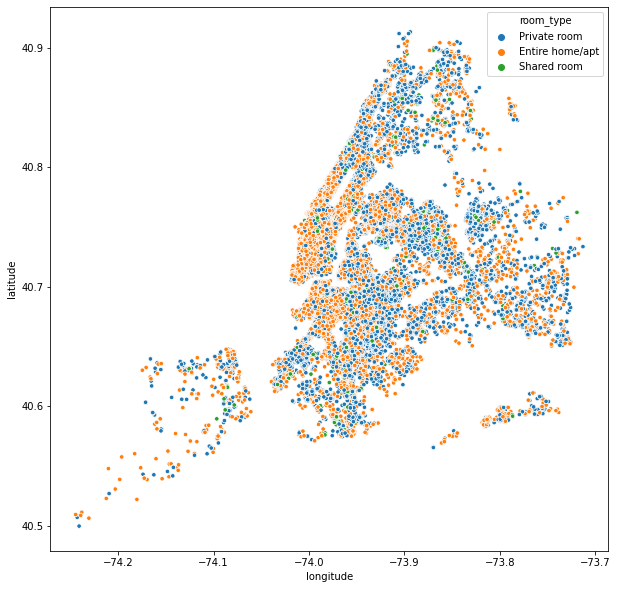

In [0]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude', hue='room_type',s=20, data=df)

##Airbnb Prices

####Displaying Price Distribution


The price distrbution seems to be highly left - skewed. 

Text(0, 0.5, 'Distribution')

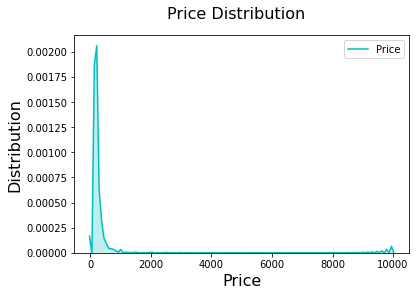

In [0]:
x = df["price"]
fig = sns.kdeplot(x, shade=True, label="Price", color="c")
fig.figure.suptitle("Price Distribution", fontsize = 16)
plt.xlabel('Price', fontsize=16)
plt.ylabel('Distribution', fontsize=16)

####Removing Outliers

The price distribution depicts some price value exist at the far right end. This means that the data consists of outliers which must be removed. Any Airbnb with price greater than three standard deviations is removed. 

In [0]:
#Dropping the outlier rows with standard deviation
factor = 3
upper_lim = df['price'].mean () + df['price'].std () * factor
lower_lim = df['price'].mean () - df['price'].std () * factor

df = df[(df['price'] < upper_lim) & (df['price'] > lower_lim)]

####Log - transforming Price 

The above distribution graph shows that there is a right-skewed distribution on price. This means there is a positive skewness. Log transformation will be used to make this feature less skewed. This will help to make easier interpretation and better statistical analysis

Since division by zero is a problem, log+1 transformation would be better. With help of log transformation, now, price feature have normal distribution.
The good fit indicates that normality is a reasonable approximation.

Text(0.5, 1.0, 'Log-Price Distribution Plot')

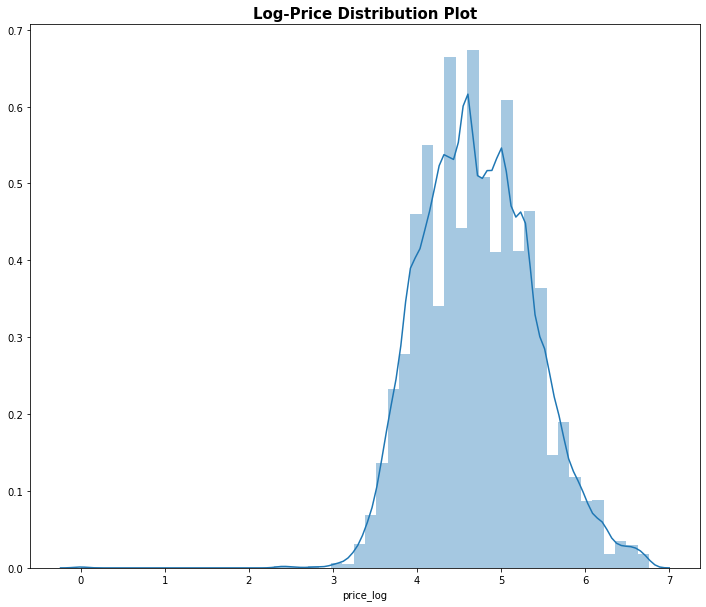

In [0]:
df['price_log'] = np.log(df.price+1)
plt.figure(figsize=(12,10))
sns.distplot(df['price_log'])
plt.title("Log-Price Distribution Plot",size=15, weight='bold')

####Total Number of Airbnb in each Price Category

Airbnb Prices have been divided into 4 categories (e.i. transformed into categorical data):


1.   Low
2.   Moderate
3.   High
4.   Very High 



In [0]:
def price_categorize(p):
  if p >= 0 and p <= 100:
    return "Low"

  elif p >= 101 and p <= 200:
    return "Moderate"

  elif p >= 201 and p <= 300:
    return "High"

  else:
    return "Very High"

df["price category"] = df["price"].apply(price_categorize)

Thereafter, the number of Airbnbs for each price groups is visualized with the help of a bar chart. The result shows most of the Airbnbs have a low price per night ($0 - $100), while the Airbnbs with 'Very High' prices ( > $300) are less in amount.

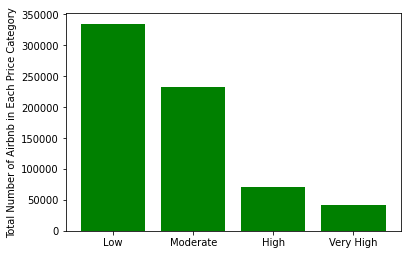

In [0]:
grouped = df.groupby("price category")

a = grouped.get_group('Low').size
b = grouped.get_group('Moderate').size
c = grouped.get_group('High').size
d = grouped.get_group('Very High').size

ydata =[int(a),int(b),int(c),int(d)]
xdata =["Low","Moderate","High", "Very High"]
plt.bar(xdata,ydata, color='green') 
plt.ylabel("Total Number of Airbnb in Each Price Category") 
plt.show()

####Analyzing Price Category in Each Borough

A scatterplot is used to visualize whether a certain price category dominates any Borough. However, the results show that 'Low' price is wide-spread throughout all Boroughs as well as 'Moderate' prices, albeit less; whereas, 'High' and 'Very High' prices are concentrated in a small region of Manhattan. 

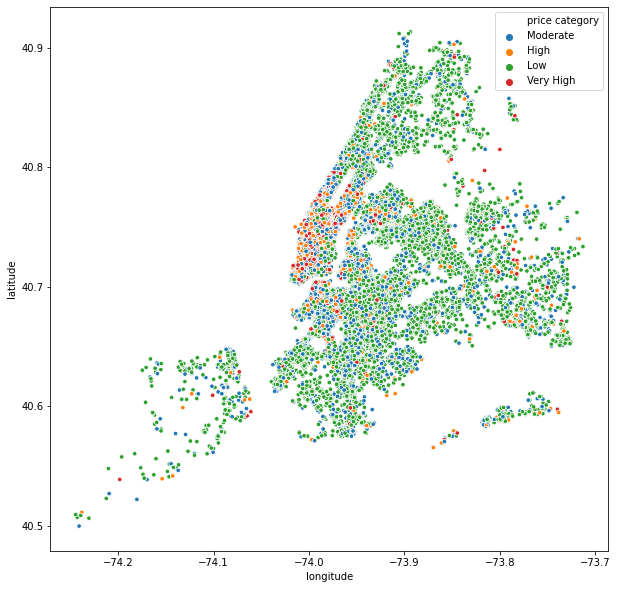

In [0]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude', hue='price category',s=20, data=df)

####Density and Distribution Of Prices for each Borough

In [0]:
#Brooklyn
sub_1=df.loc[df['boroname'] == 'Brooklyn']
price_sub1=sub_1[['price']]
#Manhattan
sub_2=df.loc[df['boroname'] == 'Manhattan']
price_sub2=sub_2[['price']]
#Queens
sub_3=df.loc[df['boroname'] == 'Queens']
price_sub3=sub_3[['price']]
#Staten Island
sub_4=df.loc[df['boroname'] == 'Staten Island']
price_sub4=sub_4[['price']]
#Bronx
sub_5=df.loc[df['boroname'] == 'Bronx']
price_sub5=sub_5[['price']]
#putting all the prices' dfs in the list
price_list_by_n=[price_sub1, price_sub2, price_sub3, price_sub4, price_sub5]

#creating an empty list that we will append later with price distributions for each neighbourhood_group
p_l_b_n_2=[]
#creating list with known values in neighbourhood_group column
nei_list=['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']
#creating a for loop to get statistics for price ranges and append it to our empty list
for x in price_list_by_n:
    i=x.describe(percentiles=[.25, .50, .75])
    i=i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'}, inplace=True)
    p_l_b_n_2.append(i)
#changing names of the price column to the area name for easier reading of the table    
p_l_b_n_2[0].rename(columns={'price':nei_list[0]}, inplace=True)
p_l_b_n_2[1].rename(columns={'price':nei_list[1]}, inplace=True)
p_l_b_n_2[2].rename(columns={'price':nei_list[2]}, inplace=True)
p_l_b_n_2[3].rename(columns={'price':nei_list[3]}, inplace=True)
p_l_b_n_2[4].rename(columns={'price':nei_list[4]}, inplace=True)
#finilizing our dataframe for final view    
stat_df=p_l_b_n_2
#creating an empty list that we will append later with price distributions for each neighbourhood_group
p_l_b_n_2=[]
#creating list with known values in neighbourhood_group column
nei_list=['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']
#creating a for loop to get statistics for price ranges and append it to our empty list
for x in price_list_by_n:
    i=x.describe(percentiles=[.25, .50, .75])
    i=i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'}, inplace=True)
    p_l_b_n_2.append(i)
#changing names of the price column to the area name for easier reading of the table    
p_l_b_n_2[0].rename(columns={'price':nei_list[0]}, inplace=True)
p_l_b_n_2[1].rename(columns={'price':nei_list[1]}, inplace=True)
p_l_b_n_2[2].rename(columns={'price':nei_list[2]}, inplace=True)
p_l_b_n_2[3].rename(columns={'price':nei_list[3]}, inplace=True)
p_l_b_n_2[4].rename(columns={'price':nei_list[4]}, inplace=True)
#finilizing our dataframe for final view    
stat_df=p_l_b_n_2
stat_df=[df.set_index('Stats') for df in stat_df]
stat_df=stat_df[0].join(stat_df[1:])
stat_df


,Brooklyn,Manhattan,Queens,Staten Island,Bronx
Stats,,,,,
min,0.0,0.0,10.0,13.0,0.0
25%,60.0,95.0,50.0,50.0,45.0
50%,90.0,149.0,75.0,75.0,65.0
75%,149.0,215.0,110.0,109.0,99.0
max,860.0,860.0,750.0,800.0,800.0


A violin plot is used to display the density and distribution of prices in each Borough. We can set up that the average of all the apartment & room prices are between 50 - 200 dollars.On the other hand, Manhattan and Brooklyn boroughs seem to be overpriced, with the majority of density in prices between 200 - 400 dollars. Furthermore, there is a notice over cost if you'd like to rent a room/apartment in the Manhattan neighbourhood group between 100 - 600 dollars.

Text(0.5, 1.0, 'Density and distribution of prices for each borough')

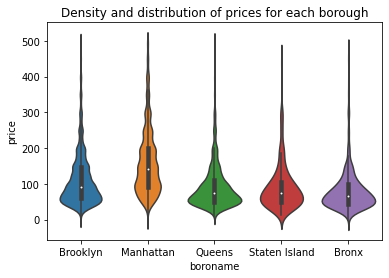

In [0]:
#we can see from our statistical table that we have some extreme values, therefore we need to remove them for the sake of a better visualization
#creating a sub-dataframe with no extreme values / less than 500
sub_6=df[df.price < 500]
#using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(data=sub_6, x='boroname', y='price')
viz_2.set_title('Density and distribution of prices for each borough')

####Distribution Price by Boroughs


In [0]:
a = df[df["boroname"] == 'Brooklyn']
b = df[df["boroname"] == 'Queens']
c = df[df["boroname"] == 'Manhattan']
d = df[df["boroname"] == 'Staten Island']
e = df[df["boroname"] == 'Bronx']

a = a["price_log"]
b = b["price_log"]
c = c["price_log"]
d = d["price_log"]
e = e["price_log"]

Text(0.5, 0.98, 'Price Distribution For Brooklyn')

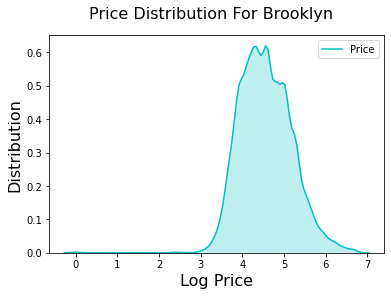

In [0]:

fig = sns.kdeplot(a, shade=True, label="Price", color="c")
plt.xlabel('Log Price', fontsize=16)
plt.ylabel('Distribution', fontsize=16)
fig.figure.suptitle('Price Distribution For Brooklyn', fontsize = 16)

Text(0.5, 0.98, 'Price Distribution For Queens')

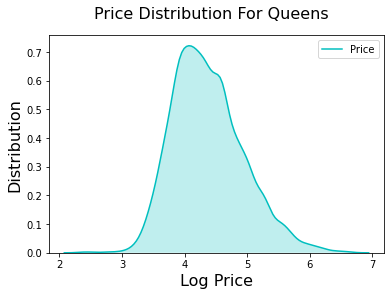

In [0]:
fig = sns.kdeplot(b, shade=True, label="Price", color="c")
plt.ylabel('Distribution', fontsize=16)
plt.xlabel('Log Price', fontsize=16)
fig.figure.suptitle('Price Distribution For Queens', fontsize = 16)

Text(0.5, 0.98, 'Price Distribution For Manhattan')

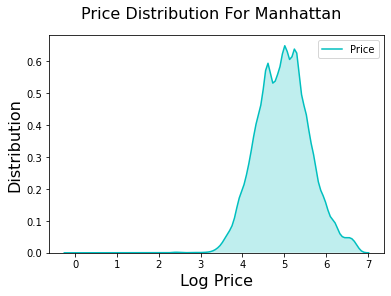

In [0]:
fig = sns.kdeplot(c, shade=True, label="Price", color="c")
plt.ylabel('Distribution', fontsize=16)
plt.xlabel('Log Price', fontsize=16)
fig.figure.suptitle('Price Distribution For Manhattan', fontsize = 16)

Text(0.5, 0.98, 'Price Distribution For Staten Islands')

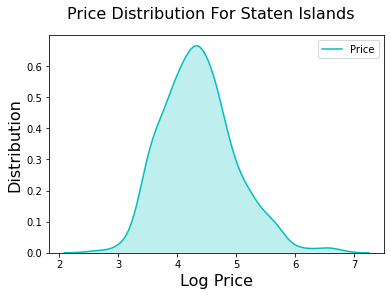

In [0]:
fig = sns.kdeplot(d, shade=True, label="Price", color="c")
plt.ylabel('Distribution', fontsize=16)
plt.xlabel('Log Price', fontsize=16)
fig.figure.suptitle('Price Distribution For Staten Islands', fontsize = 16)

Text(0.5, 0.98, 'Price Distribution For Bronx')

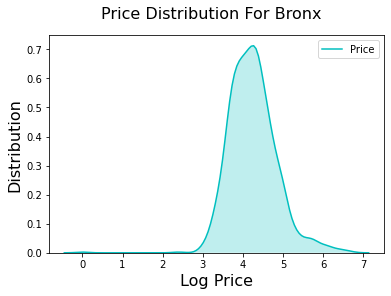

In [0]:
fig = sns.kdeplot(e, shade=True, label="Price", color="c")
plt.ylabel('Distribution', fontsize=16)
plt.xlabel('Log Price', fontsize=16)
fig.figure.suptitle('Price Distribution For Bronx', fontsize = 16)

##Minimum Nights To Book Airbnb 

####Displaying Distribution for Minimum Nights

In [0]:
df["minimum_nights"].min()

1

In [0]:
df["minimum_nights"].max()

1250

The distribution is highly skewed towards the left. 

Text(0.5, 0.98, 'Minimum nights Distribution')

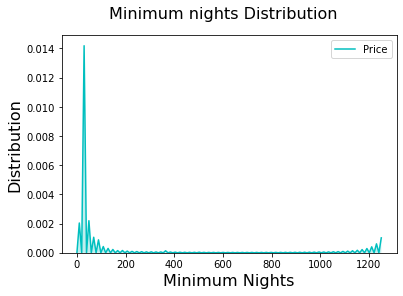

In [0]:
x = df["minimum_nights"]

fig = sns.kdeplot(x, shade=True, label="Price", color="c")
plt.ylabel('Distribution', fontsize=16)
plt.xlabel('Minimum Nights', fontsize=16)
fig.figure.suptitle('Minimum nights Distribution', fontsize = 16)

####Removing Outliers

The minimum nights distribution depicts some values exist at the far left end. This means that the data consists of outliers which must be removed. Any Airbnb with minimum night greater than three standard deviations is removed. 

In [0]:
factor = 3
upper_lim = df['minimum_nights'].mean () + df['minimum_nights'].std () * factor
lower_lim = df['minimum_nights'].mean () - df['minimum_nights'].std () * factor

df = df[(df['minimum_nights'] < upper_lim) & (df['minimum_nights'] > lower_lim)]

####Correlation Between Minimum Nights and Price of Airbnb


The scatter plot and line of regression depict that no strong correlation exists between price and number of minimum nights, since some points are further away while some are clustered towards the far left end.

Text(0.5, 0.98, 'Correlation Between Price and Minimum Nights')

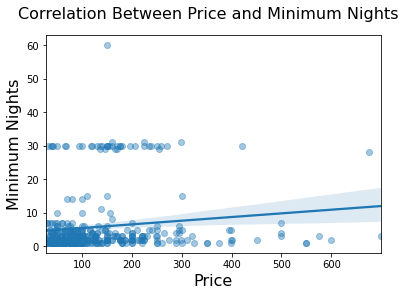

In [0]:
temp = df[["price","minimum_nights"]].sample(n=400)
fig = sns.regplot(x=temp["price"], y=temp["minimum_nights"], scatter_kws={'alpha': 0.4})
plt.xlabel('Price', fontsize=16)
plt.ylabel('Minimum Nights', fontsize=16)
fig.figure.suptitle('Correlation Between Price and Minimum Nights', fontsize = 16)


##Number of Reviews

####Displaying Number of Reviews Distribution

The distribution is skewed towards the left. It seems that most Airbnbs have number of reviews between 1 and 50.

Text(0.5, 0.98, 'Number of Reviews Distribution')

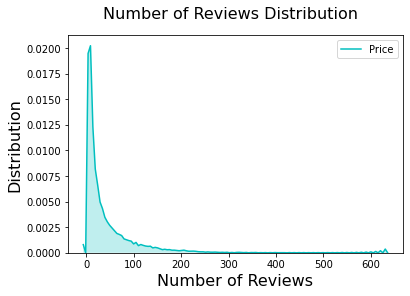

In [0]:
x = df["number_of_reviews"]
fig = sns.kdeplot(x, shade=True, label="Price", color="c")
plt.ylabel('Distribution', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=16)
fig.figure.suptitle('Number of Reviews Distribution', fontsize = 16)

####Removing Outliers

The distribution for number of reviews depicts some values exist at the far right end. This means that the data consists of outliers which must be removed. Any Airbnb with number of reviews greater than three standard deviations is removed. 

In [0]:
factor = 3
upper_lim = df['number_of_reviews'].mean () + df['number_of_reviews'].std () * factor
lower_lim = df['number_of_reviews'].mean () - df['number_of_reviews'].std () * factor

df = df[(df['number_of_reviews'] < upper_lim) & (df['number_of_reviews'] > lower_lim)]

####Correlation Between Number of Reviews and Price of Airbnb

The scatter plot and line of regression depict that no strong correlation exists between price and number of reviews, since some points are further away while some are clustered towards the far left end.

Text(0.5, 0.98, 'Correlation Between Price and Number of Reviews')

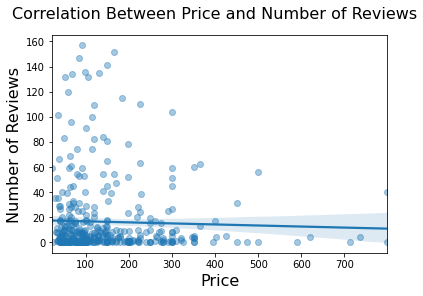

In [0]:
temp = df[["price","number_of_reviews"]].sample(n=400)
fig = sns.regplot(x=temp["price"], y=temp["number_of_reviews"], scatter_kws={'alpha': 0.4})
plt.xlabel('Price', fontsize=16)
plt.ylabel('Number of Reviews', fontsize=16)
fig.figure.suptitle('Correlation Between Price and Number of Reviews', fontsize = 16)

##Availability of Airbnbs


###Displaying availability distribution

Text(0.5, 0.98, 'Availability Distribution')

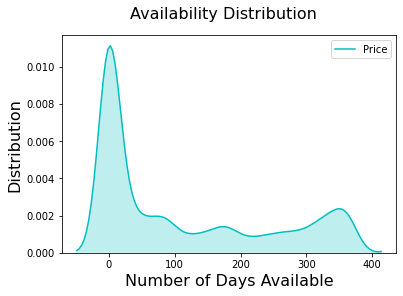

In [0]:
x = df["availability_365"]

fig = sns.kdeplot(x, shade=True, label="Price", color="c")
plt.ylabel('Distribution', fontsize=16)
plt.xlabel('Number of Days Available', fontsize=16)
fig.figure.suptitle('Availability Distribution', fontsize = 16)

###Correlation Between Availability and Price of Airbnbs

The scatter plot and line of regression depict that no strong correlation exists between price and availability, since some points are further away from the line of regression.

Text(0.5, 0.98, 'Correlation Between Availability and Price of Airbnb')

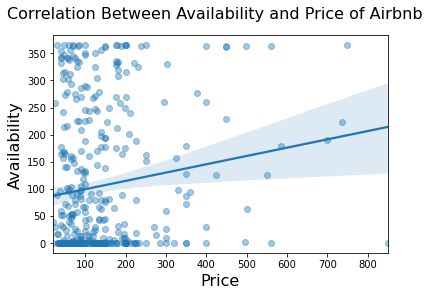

In [0]:
temp = df[["price","availability_365"]].sample(n=400)
fig = sns.regplot(x=temp["price"], y=temp["availability_365"], scatter_kws={'alpha': 0.4})
plt.xlabel('Price', fontsize=16)
plt.ylabel('Availability', fontsize=16)
fig.figure.suptitle('Correlation Between Availability and Price of Airbnb', fontsize = 16)

##Locations of Nearby Parks and Events

The external data set, [link](https://drive.google.com/file/d/11IQ1sB4Aq-0azCn4Xvc0eVEqgKHWd3fK/view?usp=sharing),  provides a list of parks and events in 2019 with their latitude and longitude and other info. The latitude and longitude were the only information extracted from the data set to check if having a nearby park or event can have any  correlation with price.


####Finding Distance to Nearest Park or Event

In [0]:
data_path = "/content/gdrive/My Drive"
filename = "ParksEvents.csv"

pf = pd.read_csv(join(data_path, filename), delimiter=",")

In [0]:
pf.head()

,event_id,name,park_id,lat,long,address,zip,borough,accessible
0,114666,Pier 2,B431,40.699449,-73.998758,NaN,NaN,B,1.0
1,167556,Pier 6,B431,40.692600,-74.001900,NaN,11201.0,B,NaN
2,152703,Kids Playground,M098,40.730795,-73.996736,NaN,NaN,M,NaN
3,90182,The Green,M008,40.753906,-73.984642,NaN,NaN,M,1.0
4,76384,First Park,M124,40.723499,-73.989799,NaN,10002.0,M,NaN


In [0]:
pf.shape

(95796, 9)

In [0]:
def coor(row):
  return np.array([row["latitude"],row["longitude"]])
df["cart"] = df.apply(coor,axis=1)

In [0]:
import scipy
combined_x_y_arrays = np.dstack([pf["lat"].ravel(),pf["long"].ravel()])[0]
mytree = scipy.spatial.cKDTree(combined_x_y_arrays)

def do_kdtree(row):
    point = row["cart"]
    dist, indexes = mytree.query(point)
    end = combined_x_y_arrays[indexes]
    return geodesic(point, end).meters
df["distance to nearest park or event"] = df.apply(do_kdtree,axis=1)
df.head()

,id,host_id,boroname,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,price_log,price category,cart,distance to nearest park or event
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365,5.010635,Moderate,"[40.647490000000005, -73.97237]",394.584015
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355,5.420535,High,"[40.75362, -73.98376999999999]",14.263708
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365,5.017280,Moderate,"[40.809020000000004, -73.9419]",88.880392
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0,4.394449,Low,"[40.79851, -73.94399]",127.865889
5,5099,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,1,129,5.303305,Moderate,"[40.74767, -73.975]",257.221457


####Displaying Distribution For Distance to Nearest Park or Event

In [0]:
df["distance to nearest park or event"].min()

1.2681093724465347

In [0]:
df["distance to nearest park or event"].max()

1877.3005750734117

Distribution for smallest distance to the nearest park/event is skewed to the left. 

Text(0.5, 0.98, 'Distribution for Distance to Nearest Park/Event')

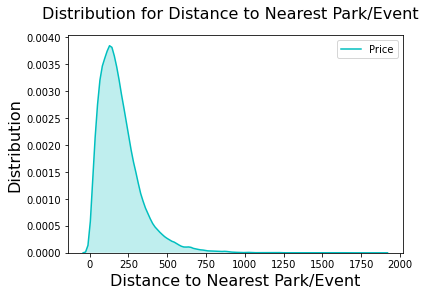

In [0]:
x = df["distance to nearest park or event"]
fig = sns.kdeplot(x, shade=True, label="Price", color="c")
plt.ylabel('Distribution', fontsize=16)
plt.xlabel('Distance to Nearest Park/Event', fontsize=16)
fig.figure.suptitle('Distribution for Distance to Nearest Park/Event', fontsize = 16)

The above distribution graph shows that there is a left-skewed distribution on smallest distance to park/event. This means there is a positive skewness. It also means that most airbnbs are at most 600m away from a park or event. Log transformation will be used to make this feature less skewed. This will help to make easier interpretation and better statistical analysis



Text(0.5, 1.0, 'Log-Dist_to_Park_Event Distribution Plot')

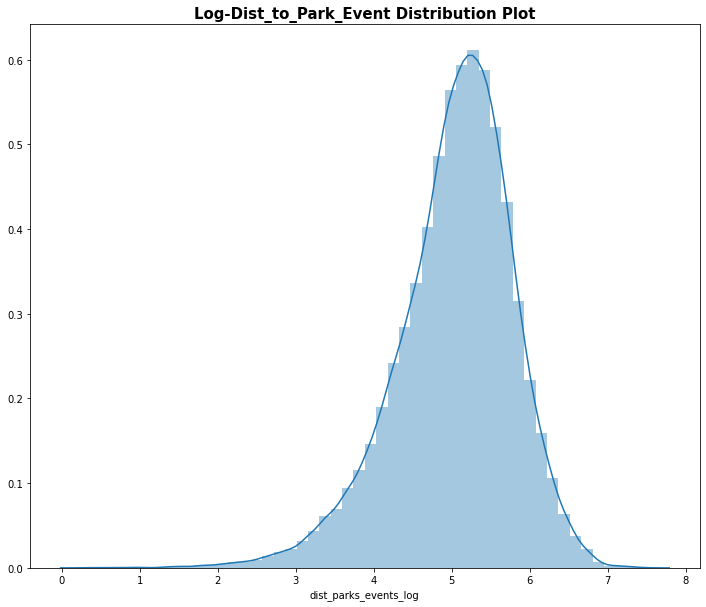

In [0]:
df['dist_parks_events_log'] = np.log(df["distance to nearest park or event"])
plt.figure(figsize=(12,10))
sns.distplot(df['dist_parks_events_log'])
plt.title("Log-Dist_to_Park_Event Distribution Plot",size=15, weight='bold')

####Removing Outliers

The distribution for distance to nearest park or event depicts some values exist at the far right end. This means that the data consists of outliers which must be removed. Any Airbnb with distance to nearest park or event greater than three standard deviations is removed. 

In [0]:
factor = 3
upper_lim = df['distance to nearest park or event'].mean () + df['distance to nearest park or event'].std () * factor
lower_lim = df['distance to nearest park or event'].mean () - df['distance to nearest park or event'].std () * factor

df = df[(df['distance to nearest park or event'] < upper_lim) & (df['distance to nearest park or event'] > lower_lim)]

####Correlation Between Distance to Nearest Park or Event and Airbnb Price

The scatter plot and line of regression depict that no strong correlation exists between price and distance to nearest park or event, since some points are further away from the line of regression and many poins are clustered towards the left.

Text(0.5, 0.98, 'Correlation Between Price and Distance to Nearest Park or Event')

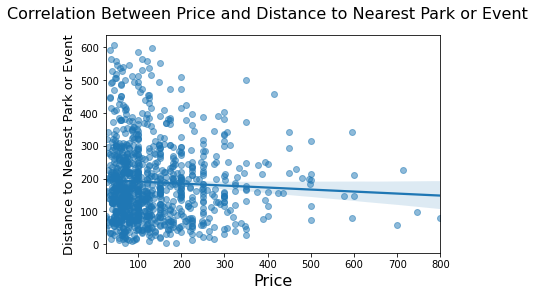

In [0]:
pr_pe = df[["price", "distance to nearest park or event"]].sample(1000)
pri=pr_pe["distance to nearest park or event"]
pe=pr_pe["price"]
fig = sns.regplot(pe,pri, scatter_kws={'alpha':0.5})
plt.xlabel('Price', fontsize=16)
plt.ylabel('Distance to Nearest Park or Event', fontsize=13)
fig.figure.suptitle('Correlation Between Price and Distance to Nearest Park or Event', fontsize = 16)

##Locations of Nearby Subway Stations

The external data set, [link](https://drive.google.com/file/d/1RRmXEl-vKcgUFcJSHfxy4GHvYpr56kWk/view?usp=sharing), provides a list of subway stations with their latitude and longitude and other attributes. The latitude and longitude were the only information extracted from that data to check if the closiness of an Airbnb to a subway station is correlated with the price of the Airbnb.


####Finding Distance to Nearest Subway station

In [0]:
data_path = "/content/gdrive/My Drive"
filename = "NYC_Transit_Subway_Entrance_And_Exit_Data.csv"

sdf = pd.read_csv(join(data_path, filename), delimiter=",")

In [0]:
sdf.shape

(1868, 32)

In [0]:
sdf.head()

,Division,Line,Station Name,Station Latitude,Station Longitude,Route1,Route2,Route3,Route4,Route5,Route6,Route7,Route8,Route9,Route10,Route11,Entrance Type,Entry,Exit Only,Vending,Staffing,Staff Hours,ADA,ADA Notes,Free Crossover,North South Street,East West Street,Corner,Entrance Latitude,Entrance Longitude,Station Location,Entrance Location
0,BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,NONE,NaN,False,NaN,False,4th Ave,25th St,SW,40.660489,-73.998220,"(40.660397, -73.998091)","(40.660489, -73.99822)"
1,BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,False,4th Ave,25th St,SE,40.660323,-73.997952,"(40.660397, -73.998091)","(40.660323, -73.997952)"
2,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,True,4th Ave,36th St,NW,40.654676,-74.004306,"(40.655144, -74.003549)","(40.654676, -74.004306)"
3,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,True,4th Ave,36th St,NE,40.654365,-74.004113,"(40.655144, -74.003549)","(40.654365, -74.004113)"
4,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,True,4th Ave,36th St,NW,40.654490,-74.004499,"(40.655144, -74.003549)","(40.65449, -74.004499)"


In [0]:
import scipy
from geopy.distance import geodesic

combined_x_y_arrays = np.dstack([sdf["Station Latitude"].ravel(),sdf["Station Longitude"].ravel()])[0]
mytree = scipy.spatial.cKDTree(combined_x_y_arrays)

def do_kdtree(row):
    point = row["cart"]
    dist, indexes = mytree.query(point)
    end = combined_x_y_arrays[indexes]
    return geodesic(point, end).meters
df["distance to nearest subwaystation"] = df.apply(do_kdtree,axis=1)
df.head()

,id,host_id,boroname,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,price_log,price category,cart,distance to nearest park or event,dist_parks_events_log,distance to nearest subwaystation
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365,5.010635,Moderate,"[40.647490000000005, -73.97237]",394.584015,5.977832,465.433844
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355,5.420535,High,"[40.75362, -73.98376999999999]",14.263708,2.657718,94.983136
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365,5.017280,Moderate,"[40.809020000000004, -73.9419]",88.880392,4.487292,334.336244
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0,4.394449,Low,"[40.79851, -73.94399]",127.865889,4.850982,200.694925
5,5099,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,1,129,5.303305,Moderate,"[40.74767, -73.975]",257.221457,5.549937,426.808249


####Displaying Distribution For Distance to Nearest Subway Station

In [0]:
df["distance to nearest subwaystation"].min()

0.907523521738452

In [0]:
df["distance to nearest subwaystation"].max()

22012.330563513704

Text(0.5, 0.98, 'Distribution for Nearest Subway Entrance')

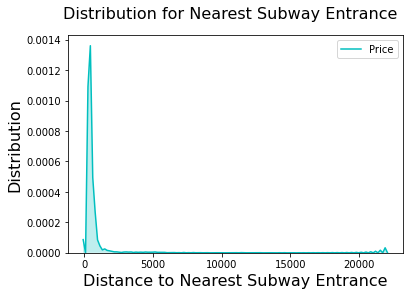

In [0]:
x = df["distance to nearest subwaystation"]
fig = sns.kdeplot(x, shade=True, label="Price", color="c")
plt.ylabel('Distribution', fontsize=16)
plt.xlabel('Distance to Nearest Subway Entrance', fontsize=16)
fig.figure.suptitle('Distribution for Nearest Subway Entrance', fontsize = 16)

The above distribution graph shows that there is a left-skewed distribution on smallest distance to park/event. This means there is a positive skewness. It also means that most airbnbs are located atleast 1000m near a subway station. Log transformation will be used to make this feature less skewed. This will help to make easier interpretation and better statistical analysis



Text(0.5, 1.0, 'Log-Dist_to_SubwayStation Distribution Plot')

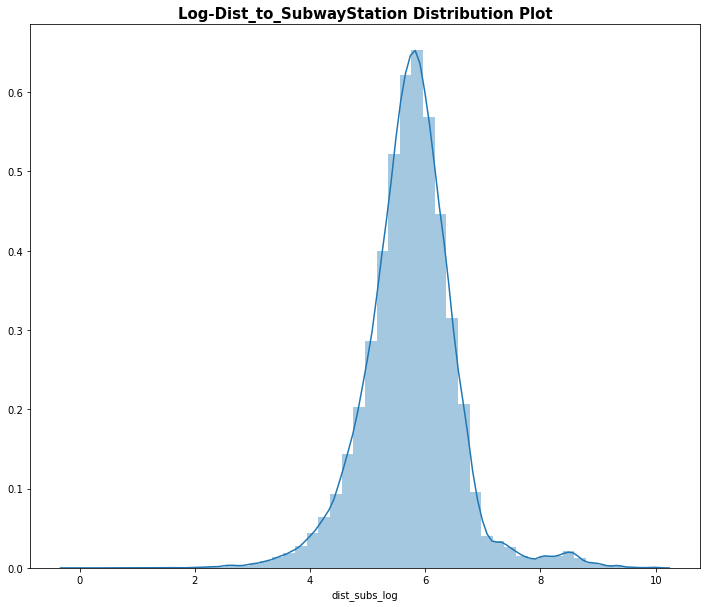

In [0]:
df['dist_subs_log'] = np.log(df["distance to nearest subwaystation"])
plt.figure(figsize=(12,10))
sns.distplot(df['dist_subs_log'])
plt.title("Log-Dist_to_SubwayStation Distribution Plot",size=15, weight='bold')

####Removing Outliers

The distribution for distance to nearest subway station depicts some values exist at the far right end. This means that the data consists of outliers which must be removed. Any Airbnb with distance to subway station greater than three standard deviations is removed. 

In [0]:
factor = 3
upper_lim = df['distance to nearest subwaystation'].mean () + df['distance to nearest subwaystation'].std () * factor
lower_lim = df['distance to nearest subwaystation'].mean () - df['distance to nearest subwaystation'].std () * factor

df = df[(df['distance to nearest subwaystation'] < upper_lim) & (df['distance to nearest subwaystation'] > lower_lim)]

####Correlation Between Distance To Nearest Subway Station  and Airbnb Price

The scatter plot and line of regression depict that no strong correlation exists between price and distance to nearest subway station, since some points are further away from the line of regression and many poins are clustered towards the left.

Text(0.5, 0.98, 'Correlation Between Price and Distance to Nearest Park or Event')

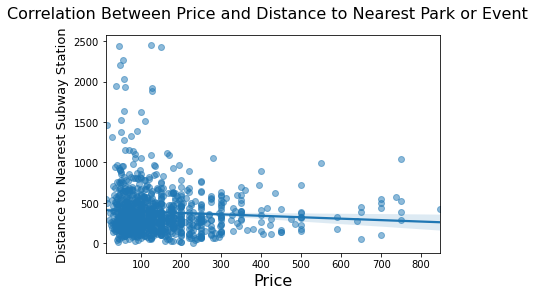

In [0]:
pr_sub = df[["price", "distance to nearest subwaystation"]].sample(1000)
pri=pr_sub["distance to nearest subwaystation"]
subs=pr_sub["price"]
fig = sns.regplot(subs,pri, scatter_kws={'alpha':0.5})
plt.xlabel('Price', fontsize=16)
plt.ylabel('Distance to Nearest Subway Station', fontsize=13)
fig.figure.suptitle('Correlation Between Price and Distance to Nearest Park or Event', fontsize = 16)

##Airbnb Room Type

####Converting Room Type to Numerical Data

In [0]:
def type_categorize(p):
  if p == 'Private room':
    return 1

  elif p == 'Entire home/apt':
    return 2

  else:
    return 3

df["room_type_numerical"] = df["room_type"].apply(type_categorize)

##Correlation of Price With Other Features

The correlation table shows us that there is no strong relationship between price and other features.
However price_log shows some correleations with room_types.

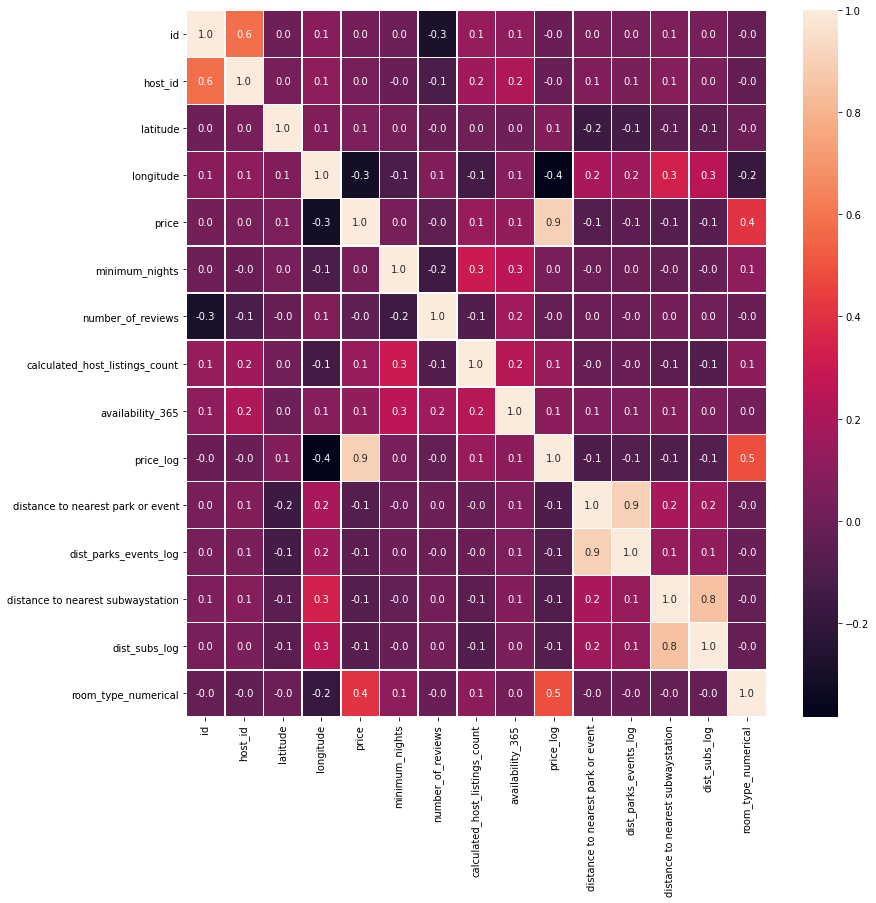

In [0]:
f,ax = plt.subplots(figsize=(13, 13))
sns.heatmap(df.drop('neighbourhood', axis = 1).corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

The correlation matrix helps to identify the variables that are/are not correlated. Following are the correlation coefficients for price with other features:

1.  room type -> 0.4
3.  distance to nearest subway station -> -0.1
4.  distance to airport -> 0.1
5.  availability -> 0.1
6.  number of reviews -> 0.1
7.  minimum nights -> 0.0 


None of the correlation coefficients are closer to 1 or -1, which suggests that there does not exist any strong linear relationship between price and other variables, proving our initial assumptions wrong. 

#Part 2: Hypothesis Testing 

##T - test

T - test is being used to find out if there is any significant difference between the mean prices of Airbnb in Manhattan and Brooklyn. 

$H_0: \mu_{1} = \mu_{2}$

$H_A: \mu_{1} \neq \mu_{2}$

In [0]:
grouped = df.groupby("boroname")

m = grouped.get_group('Manhattan')
b = grouped.get_group('Brooklyn')

manhattan = m["price_log"]
brooklyn = b["price_log"]

####Visualizing Price Distribution

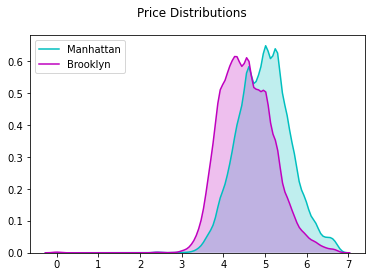

In [0]:
sns.kdeplot(m["price_log"], shade=True, label="Manhattan", color="c")
sns.kdeplot(b["price_log"], shade=True, label="Brooklyn", color="m")

plt.suptitle("Price Distributions")
plt.show()

####Conducting T - Test

In [0]:
tcrit, pval = stats.ttest_ind(manhattan, brooklyn, equal_var=False)
print('tcrit = ' , tcrit)
print('pval = ', pval)
if pval < 0.05:    # alpha value is 0.05 or 5%
   print("we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

tcrit =  67.13882888659026
pval =  0.0
we are rejecting null hypothesis


If we set the significance level as 0.05, we can reject the null hypothesis. In addition, the test score is positive which indicates that the mean price of Airbnb is higher in Manhattan than Brooklyn.

#Findings 

All of the features show little to no correlation with price, proving our initial assumptions wrong. However, we found that the neighbourhood group may affect the price of an Airbnb, as the average prices for Manhattan are much higher than the others. 

#Part 3: Machine Learning



In [0]:
df.head()

,id,host_id,boroname,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,price_log,price category,cart,distance to nearest park or event,dist_parks_events_log,distance to nearest subwaystation,dist_subs_log,room_type_numerical
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365,5.010635,Moderate,"[40.647490000000005, -73.97237]",394.584015,5.977832,465.433844,6.142970,1
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355,5.420535,High,"[40.75362, -73.98376999999999]",14.263708,2.657718,94.983136,4.553699,2
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365,5.017280,Moderate,"[40.809020000000004, -73.9419]",88.880392,4.487292,334.336244,5.812147,1
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0,4.394449,Low,"[40.79851, -73.94399]",127.865889,4.850982,200.694925,5.301786,2
5,5099,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,1,129,5.303305,Moderate,"[40.74767, -73.975]",257.221457,5.549937,426.808249,6.056335,2


##One Hot Encoding 

One hot encoding is done to change the categorical data such as boroughs and room types to change them to type of 0 and 1. Ordinal encoding was not chosen as a category with higher value would be given more importance in the model. Hence, one hot encoding seemed like the best choice.  

In [0]:
df = df.drop(["longitude","latitude","id","host_id","neighbourhood", "cart", "room_type_numerical", "dist_parks_events_log","dist_subs_log", "price_log", "price category"], axis=1)
df = pd.get_dummies(df)
df.head()


,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,distance to nearest park or event,distance to nearest subwaystation,boroname_Bronx,boroname_Brooklyn,boroname_Manhattan,boroname_Queens,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,149,1,9,6,365,394.584015,465.433844,0,1,0,0,0,1,0
1,225,1,45,2,355,14.263708,94.983136,0,0,1,0,1,0,0
2,150,3,0,1,365,88.880392,334.336244,0,0,1,0,0,1,0
4,80,10,9,1,0,127.865889,200.694925,0,0,1,0,1,0,0
5,200,3,74,1,129,257.221457,426.808249,0,0,1,0,1,0,0


We have chosen Random Forest and KNN for our price prediction based on its advantages and disadvantages. 

For Random forest:

Advantages:

1. Random Forest is based on the bagging algorithm and uses Ensemble Learning technique. It creates as many trees on the subset of the data and combines the output of all the trees. In this way it reduces overfitting problem in decision trees and also reduces the variance and therefore improves the accuracy.

2. Random Forest can be used to solve both classification as well as regression problems.

3. Random Forest works well with both categorical and continuous variables.

4. Random Forest can automatically handle missing values.

5. No feature scaling (standardization and normalization) required in case of Random Forest as it uses rule based approach instead of distance calculation.

6. Non linear parameters don't affect the performance of a Random Forest unlike curve based algorithms. So, if there is high non-linearity between the independent variables, Random Forest may outperform as compared to other curve based algorithms.

7. Random Forest can automatically handle missing values.

8. Random Forest is usually robust to outliers and can handle them automatically.

9. Random Forest algorithm is very stable. Even if a new data point is introduced in the dataset, the overall algorithm is not affected much since the new data may impact one tree, but it is very hard for it to impact all the trees.

10. Random Forest is comparatively less impacted by noise.

Disadvantages: 

1. Random Forest creates a lot of trees (unlike only one tree in case of decision tree) and combines their outputs. By default, it creates 100 trees in Python sklearn library. To do so, this algorithm requires much more computational power and resources. On the other hand decision tree is simple and does not require so much computational resources.

2. Random Forest require much more time to train as compared to decision trees as it generates a lot of trees (instead of one tree in case of decision tree) and makes decision on the majority of votes.

Based on these advantages and disadvantages, random forest seemed to be the right for the price prediction since it easily worked for a regression problem and less impacted by noise. Since the project is small-scale, the computational time did not seem to be a huge concern.



##Price Prediction Using Random Forest




First and foremost, we are separating our features and the label column. Here, we are going to deploy 80-20 partitioning.
We are using random state as 0 to ensure we obtain the same partitioning in each run.

In [0]:
X = df.drop(["price"], axis=1)
y = df["price"].values

# 80% for training and 20% for testing-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

####Feature Selection Using Random Forest

Irrelevant or partially relevant features can negatively impact model performance which is why, feature selection is done to select those features which contributed most to our prediction variable. The major reasons to do feature selection was to reduce overfitting, improve accuracy and reduce training time. Here we have done feature selection using random forest. 

First we train our model using our training values. 

In [0]:
snf = RandomForestRegressor(n_estimators = 1000, random_state = 0)
snf.fit(X_train, y_train)
y_pred_train = snf.predict(X_test)

Thereafter, we find out the most important features from our model using SelectFromModel() function. 

In [0]:
sel = SelectFromModel(snf)
sel.fit(X_train, y_train)
sel.get_support()

array([ True,  True, False,  True,  True,  True, False, False, False,
       False,  True, False, False])

Here we display the most important features and then transform our training values to only consist of the important features using transform function. 

In [0]:
x = [df.drop(["price"], axis=1).columns]
for feature_list_index in sel.get_support(indices=True):
    print(x[0][feature_list_index])
X_important_train = sel.transform(X_train)
X_important_test = sel.transform(X_test)

minimum_nights
number_of_reviews
availability_365
distance to nearest park or event
distance to nearest subwaystation
room_type_Entire home/apt


Once the important features have been identified, we create a new model and train it with the transformed training data. Thereafter, the model is used to create prediction for price values. 

In [0]:
clf = (RandomForestRegressor(n_estimators = 1000, random_state = 0))
# fit the training data
clf.fit(X_important_train, y_train)
y_pred = clf.predict(X_important_test)

Here the mean squared error and mean absolute error are displayed for our model, with and without feature selection. As it can be seen, the error increased after feature selection even though that was not expected. This is probably because feature selection cause overfitting of the model. The MAE increased from ~52 to ~58 which came at a cost of feature selection. 

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

print("\nMSE All features:", round(mean_squared_error(y_test, y_pred_train),4))
print("MSE Selected features:", round(mean_squared_error(y_test, y_pred),4))
print("\nMAE All features:", round(mean_absolute_error(y_test, y_pred_train),4))
print("MAE Selected features:", round(mean_absolute_error(y_test, y_pred),4))



MSE All features: 7316.1313
MSE Selected features: 8449.1589

MAE All features: 53.2186
MAE Selected features: 58.5848


Here the actual and predicted values are displayed. As it can be seen, the predicted values are highly different than the actual values for the model with feature selection. Hence, having a high MAE and MSE is justified. Overall, the model does not do well.

In [0]:
error_airbnb = pd.DataFrame({
        'Actual Values': np.array(y_test).round(),
        'Predicted Values': y_pred.round()}).head(20)

error_airbnb.head(5)

,Actual Values,Predicted Values
0,175,123.0
1,250,188.0
2,100,172.0
3,150,170.0
4,188,243.0


Instead of just using the error values, a kdeplot is used to plot the distribution of predicted and actual values, to help visualize the difference in the distribution for both prices. 

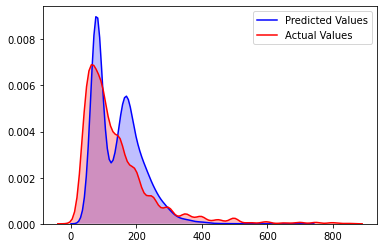

In [0]:
sns.kdeplot(y_pred, color = 'b', shade = True, label = 'Predicted Values')
sns.kdeplot(y_test, color = 'r', shade = True, label = 'Actual Values')

As the graph shows, both the predicted and actual values are left skewed. However, the predicted values have a much higher average value than the actual values. This is an accurate visualization of the differences in both types of prices. It makes it certain that the random forest does not give the correct predictions and the model can be greatly improved.

####Prediction After Standardization

Since the random forest model did not do well, we retry a new random forest model but this time standardized data was used in order to increase the accuracy of the model. This was done because our features are very different in terms of numeral scaling.

Standard Scaler function was used on our feature data. However, it was not used on the target data since after the prediction of the model, the actual and predicted values were to be displayed in original price format. 

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

cols = df.columns
scaler = preprocessing.StandardScaler()
X_important_train =(scaler.fit_transform(X_important_train))
X_important_test =(scaler.fit_transform(X_important_test))

X_train =(scaler.fit_transform(X_train))
X_test =(scaler.fit_transform(X_test))

clf.fit(X_important_train, y_train)
y_pred = clf.predict(X_important_test)

snf.fit(X_train, y_train)
y_pred_train = snf.predict(X_test)

As it can be seen, the standardization did not cause any significant difference between the previous mean absolute error and mean squared error and those for the standardized model. Errors were found out for model with features selection and without feature selection. Again, the errors are higher for standardized mdoel with feature selection compared to the other. 


In [0]:
print("\nMSE All features:", round(mean_squared_error(y_test, y_pred_train),4))
print("MSE Selected features:", round(mean_squared_error(y_test, y_pred),4))
print("\nMAE All features:", round(mean_absolute_error(y_test, y_pred_train),4))
print("MAE Selected features:", round(mean_absolute_error(y_test, y_pred),4))
print("\nAll features r2:", round(r2_score(y_test, y_pred_train),4))
print("Selected features r2:", round(r2_score(y_test, y_pred),4))
rf_mse = round(mean_squared_error(y_test, y_pred_train),4)
rf_mse_selected = round(mean_squared_error(y_test, y_pred),4)
rf_mae = round(mean_absolute_error(y_test, y_pred_train),4)
rf_mae_selected = round(mean_absolute_error(y_test, y_pred),4)
rf_r2 = round(r2_score(y_test, y_pred_train),4)
rf_r2_selected = round(r2_score(y_test, y_pred),4)


MSE All features: 8521.1218
MSE Selected features: 8599.087

MAE All features: 56.0127
MAE Selected features: 58.985

All features r2: 0.2947
Selected features r2: 0.2882


After displaying the actual and predicted values between price, it can be visualized that they are highly different and it is evident that the model does not do well even though multiple efforts were done to increase the accuracy of the model and reduce overfitting using feature selection and standardization.

In [0]:
error_airbnb = pd.DataFrame({
        'Actual Values': np.array(y_test).round(),
        'Predicted Values': y_pred.round()}).head(20)

error_airbnb.head(5)

,Actual Values,Predicted Values
0,175,126.0
1,250,184.0
2,100,169.0
3,150,169.0
4,188,240.0


Instead of just using the error values, a kdeplot is used to plot the distribution of predicted and actual values, to help visualize the difference in the distribution for both prices.

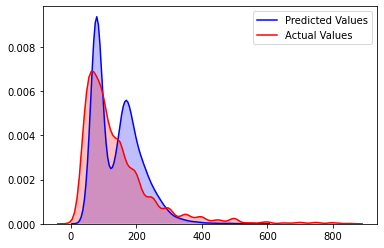

In [0]:
sns.kdeplot(y_pred, color = 'b', shade = True, label = 'Predicted Values')
sns.kdeplot(y_test, color = 'r', shade = True, label = 'Actual Values')

Even though standardization was done, still the predicted values have a much higher average value than the actual values. This is an accurate visualization of the differences in both types of prices. It makes it certain that the random forest does not give the correct predictions and standardization made no difference to the model. The model can be greatly improved.

##Price Prediction Using KNN

KNN is a very simple algorithm used to solve classification problems. KNN stands for K-Nearest Neighbors. K is the number of neighbors in KNN. Lets find out some advantages and disadvantages of KNN algorithm.

Advantages of KNN

1.  KNN is called Lazy Learner (Instance based learning). It does not learn anything in the training period. It does not derive any discriminative function from the training data. In other words, there is no training period for it. It stores the training dataset and learns from it only at the time of making real time predictions. This makes the KNN algorithm much faster than other algorithms that require training e.g. SVM, Linear Regression etc.

2. Since the KNN algorithm requires no training before making predictions, new data can be added seamlessly which will not impact the accuracy of the algorithm.

3. KNN is very easy to implement. There are only two parameters required to implement KNN i.e. the value of K and the distance function (e.g. Euclidean or Manhattan etc.)

Disadvantages of KNN

1. In large datasets, the cost of calculating the distance between the new point and each existing points is huge which degrades the performance of the algorithm.

2. The KNN algorithm doesn't work well with high dimensional data because with large number of dimensions, it becomes difficult for the algorithm to calculate the distance in each dimension.

3. We need to do feature scaling (standardization and normalization) before applying KNN algorithm to any dataset. If we don't do so, KNN may generate wrong predictions.

4. KNN is sensitive to noise in the dataset. We need to manually impute missing values and remove outliers.

Due to the benefits of KNN, this was also one of the models chosen for conducting price prediction.

Here we try to find out the best value of hyperparameter K using mean square error and regression. As it can be inferred k = 14 gives the least error, so the hyperparameter k will be equal to 14.

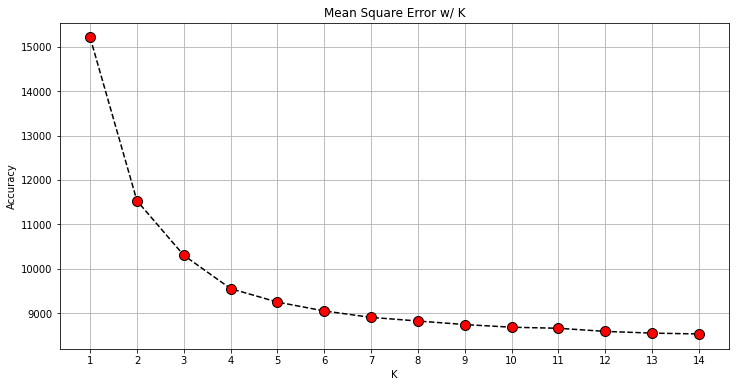

In [0]:
from sklearn.neighbors import KNeighborsRegressor

K_range = np.arange(1, 15)
mse_list = []
for k in K_range:
  # create a new model with current K
  knn = KNeighborsRegressor(n_neighbors=k)
  # fit training data
  knn.fit(X_important_train, y_train)
  # predict the validation data
  y_pred = knn.predict(X_important_test)
  # obtain the mean square error
  mse_list.append(round(mean_squared_error(y_test, y_pred),4))

plt.figure(figsize=(12, 6))  
plt.plot(K_range, mse_list, color='black', linestyle='dashed', marker='o',  
         markerfacecolor='red', markersize=10)
plt.title('Mean Square Error w/ K')  
plt.xlabel('K')  
plt.ylabel('Accuracy')
plt.xticks(K_range)
plt.grid()
plt.show()

Here were using two models knn and knn1. knn is a model for the main data features, and knn1 is for the selected features. The mean squared error and mean absolute error are displayed for our model, with and without feature selection(after standardization). As it can be seen, the error increased after feature selection. The MAE increased from ~53 to ~58 which came at a cost of feature selection probably because of overfitting.

In [0]:
# instantiate the model and set the number of neighbors to consider to 13
#####x_test,x_important_test, y_test, and y_train are used from previous section, hense they are already standardized
k=14
knn = KNeighborsRegressor(n_neighbors=14)
knn1= KNeighborsRegressor(n_neighbors=14)
#standardizing
scaler = preprocessing.StandardScaler()
X_important_train =(scaler.fit_transform(X_important_train))
X_important_test =(scaler.fit_transform(X_important_test))

X_train =(scaler.fit_transform(X_train))
X_test =(scaler.fit_transform(X_test))

knn1.fit(X_important_train, y_train)
y_pred = knn1.predict(X_important_test)

knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_test)
#values here are already standardized from previous section
print("\nMSE All features:", round(mean_squared_error(y_test, y_pred_train),4))
print("MSE Selected features:", round(mean_squared_error(y_test, y_pred),4))
print("\nMAE All features:", round(mean_absolute_error(y_test, y_pred_train),4))
print("MAE Selected features:", round(mean_absolute_error(y_test, y_pred),4))
print("\nAll features r2:", round(r2_score(y_test, y_pred_train),4))
print("Selected features r2:", round(r2_score(y_test, y_pred),4))
knn_mse = round(mean_squared_error(y_test, y_pred_train),4)
knn_mse_selected = round(mean_squared_error(y_test, y_pred),4)
knn_mae = round(mean_absolute_error(y_test, y_pred_train),4)
knn_mae_selected =  round(mean_absolute_error(y_test, y_pred),4)
knn_r2 =  round(r2_score(y_test, y_pred_train),4)
knn_r2_selected =  round(r2_score(y_test, y_pred),4)


MSE All features: 7596.0235
MSE Selected features: 8530.6789

MAE All features: 53.6955
MAE Selected features: 58.4444

All features r2: 0.3713
Selected features r2: 0.2939


After displaying the actual and predicted values between price, it can be visualized that they are highly different and it is evident that the model does not do well.

In [0]:
error_airbnb = pd.DataFrame({
        'Actual Values': np.array(y_test).round(),
        'Predicted Values': y_pred.round()})

error_airbnb.head(5)

,Actual Values,Predicted Values
0,175,96.0
1,250,198.0
2,100,184.0
3,150,142.0
4,188,197.0


Instead of just using the error values, a kdeplot is used to plot the distribution of predicted and actual values, to help visualize the difference in the distribution for both prices.

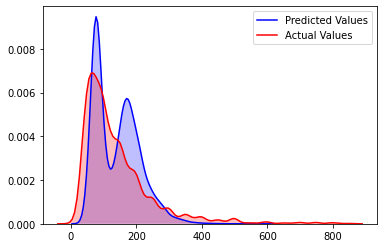

In [0]:
sns.kdeplot(y_pred, color = 'b', shade = True, label = 'Predicted Values')
sns.kdeplot(y_test, color = 'r', shade = True, label = 'Actual Values')


As the graph shows, both the predicted and actual values are left skewed. However, the predicted values have a much higher average value than the actual values. This is an accurate visualization of the differences in both types of prices. It makes it certain that the random forest does not give the correct predictions and the model can be greatly improved.

##Results

In [0]:
N = 2
rf_err_mae = (rf_mae, rf_mae_selected)
rf_err_mse = (rf_mse, rf_mse_selected)
rf_err_r2 =  (rf_r2, rf_r2_selected)
knn_err_mae = (knn_mae, knn_mae_selected)
knn_err_mse = (knn_mse, knn_mse_selected)
knn_err_r2 =  (knn_r2, knn_r2_selected)
rf_err = (rf_mae, rf_mae_selected,rf_mse, rf_mse_selected)
knn_err = (knn_mae, knn_mae_selected,knn_mse, knn_mse_selected)

Here we plot a bar chart to compare the error values of KNN and Random Forest.

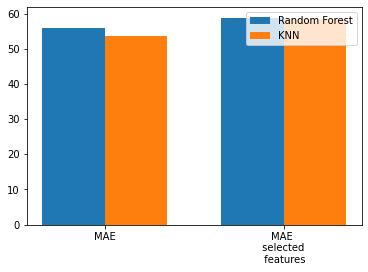

In [0]:
N = 2
ind = np.arange(N) 
width = 0.35 

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, rf_err_mae, width, label='Random Forest')
plt.bar(ind + width, knn_err_mae, width,label='KNN')

plt.xticks(ind + width / 2, ('MAE', 'MAE \n selected \n features'))
plt.legend(loc='best')
plt.show()

As it is evident, there is not much difference in the mean squared error and mean absolute error for both models. This mean that both models equally failed to perform well, probably because of overfitting and noise in data. There is a possibility that they can be greatly improved. 

Even though both models gave a very similar prediction with very similar error values, KNN seems like a better option since it takes much less computation time and RAM usage while Random Forest has a very high complexity and thus, takes much longer. One benefit of using random forest is that it did not require any standardization, and once we applied standardization it made no difference to the model, whereas KNN makes better predictions with standardization. However, this seems like a minute advantage compared to the disadvantage of high computational time for random forest.

##Conclusion

Many approaches were taken to find a relation that links price to other features, however all our approaches failed. All features coming from the main data set and from external data sets showed little to no correlation with price. In addition, two models, random forest and KNN,  were used to predict price. Both trials were in vain, for our results showed bad price predictions with really high mean squared errors. In conclusion, our solution was not applicable and our hypothesis failed. The biggest disadvantage of our approach was the time and power running the random forest model code took.

Our approach consisted of feature selection, standardization and comparing errors. However, all efforts probably resulted in overfitting and decrease in accuracy. Hence, it can be concluded that the models do not work well. 